In [1]:
#imports
import katdal
import numpy as np
import matplotlib.pylab as plt
import astropy.coordinates as ac
import functools
import healpy as hp
import optparse
import warnings
from matplotlib.backends.backend_pdf import PdfPages
import healpy as hp
from astropy import units as u
from matplotlib.offsetbox import AnchoredText
import time
import pickle
import sys
Tcmb=2.725
import katcali
import katcali.visualizer as kv
import katcali.models as km
import katcali.rfi as kr
import katcali.solver as ks
import katcali.io as kio
import katcali.label_dump as kl
import katcali.diode as kd
import katcali.filter as kf
import katcali.beam as kb
from astropy.coordinates import SkyCoord
from astropy import units as u
from scipy.sparse import coo_matrix
import astropy.wcs
from astropy.wcs.utils import skycoord_to_pixel
from astropy.wcs.utils import pixel_to_skycoord
from astropy.io import fits
from astropy.wcs import WCS

In [2]:
print 'start @ ' + time.asctime(time.localtime(time.time())) +'...'

start @ Wed Jun  8 14:10:09 2022...


In [3]:
print  plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth']
plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'] = 14, 1.5, 1.5
#plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'] = 10.0, 0.8, 1.5
print  plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth']

10.0 0.8 1.5
14.0 1.5 1.5


In [4]:
p_radec=np.loadtxt('radio_source2021.txt')


In [5]:
ch_plot=800

In [6]:
input_file='/idia/projects/hi_im/raw_vis/MeerKLASS2021/level4/data/'
output_file='./'

In [7]:
fname='1631659886'
ant='m010'

print fname, ant

1631659886 m010


In [8]:
d1=pickle.load(open(input_file+fname+'_'+ant+'_level4_data'))
print d1.keys()

['Tresi_map', 'nd_s0', 'Tsky_map', 'ra', 'timestamps', 'Tsky_ratio', 'dec']


<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>


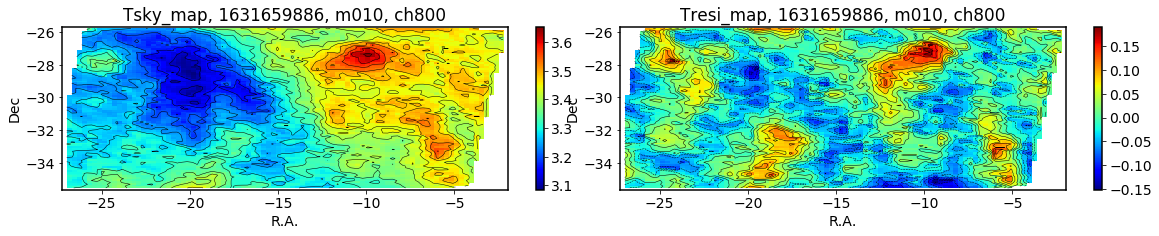

In [9]:


ra=d1['ra']
dec=d1['dec']
Tresi_map=d1['Tresi_map']
Tsky_map=d1['Tsky_map']
nd_s0=d1['nd_s0']
plt.figure(figsize=(20,3))
plt.subplots_adjust (wspace=0.0, hspace=0.2) 
plt.subplot(121)
p_data=Tsky_map[:,ch_plot]
try:
    kv.plot_data(ra,dec, p_data,gsize=90)
except(Exception):
    kv.plot_data(ra,dec, np.zeros_like(ra),gsize=90)
plt.xlabel('R.A.')
plt.ylabel('Dec')
plt.title('Tsky_map, '+fname+', '+ant+', ch'+str(ch_plot))
plt.subplot(122)
p_data=Tresi_map[:,ch_plot]
try:
    kv.plot_data(ra,dec, p_data,gsize=90)
except(Exception):
    kv.plot_data(ra,dec, np.zeros_like(ra),gsize=90)
plt.xlabel('R.A.')
plt.ylabel('Dec')
plt.title('Tresi_map, '+fname+', '+ant+', ch'+str(ch_plot))
plt.show()


In [10]:
freqs=kio.cal_freqs(range(4096))

<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>


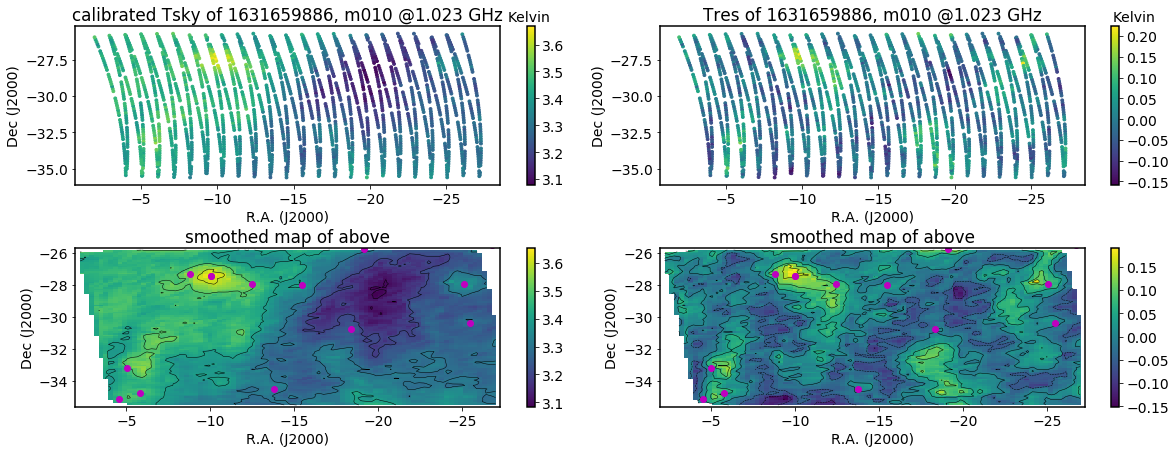

In [11]:
plot_gsize=90
plt.figure(figsize=(20,7))
plt.subplots_adjust(wspace=0.1,hspace=.4)
ax=plt.subplot(221)
p_data=Tsky_map[:,ch_plot]
plt.scatter(ra,dec, c=p_data, vmin=p_data.min(),vmax=p_data.max(), s=8, cmap=kv.cmap1())
ax.invert_xaxis()
plt.title('calibrated Tsky of '+str(fname)+', '+str(ant)+ ' @'+ str(round(freqs[ch_plot]/1e9,3))+' GHz')
plt.xlabel('R.A. (J2000)')
plt.ylabel('Dec (J2000)')
clb = plt.colorbar()
clb.set_label('Kelvin', labelpad=-35, y=1.1, rotation=0)
ax=plt.subplot(222)
p_data=Tresi_map[:,ch_plot]
plt.scatter(ra,dec, c=p_data, vmin=p_data.min(),vmax=p_data.max(), s=8, cmap=kv.cmap1())
ax.invert_xaxis()
plt.title('Tres of '+str(fname)+', '+str(ant)+ ' @'+ str(round(freqs[ch_plot]/1e9,3))+' GHz')
plt.xlabel('R.A. (J2000)')
plt.ylabel('Dec (J2000)')
clb = plt.colorbar()
clb.set_label('Kelvin', labelpad=-35, y=1.1, rotation=0)
ax=plt.subplot(223)
p_data=Tsky_map[nd_s0,ch_plot]
kv.plot_mdata(ra[nd_s0],dec[nd_s0], p_data,gsize=plot_gsize, grid_method='linear', levels=6, x_mask=1, y_mask=2, cmap=kv.cmap1())
ax.invert_xaxis()
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.title('smoothed map of above')
plt.xlabel('R.A. (J2000)')
plt.ylabel('Dec (J2000)')
ax=plt.subplot(224)
p_data=Tresi_map[nd_s0,ch_plot]
kv.plot_mdata(ra[nd_s0],dec[nd_s0], p_data,gsize=plot_gsize, grid_method='linear', levels=6, x_mask=1, y_mask=2, cmap=kv.cmap1())
ax.invert_xaxis()
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.title('smoothed map of above')
plt.xlabel('R.A. (J2000)')
plt.ylabel('Dec (J2000)')
#plt.savefig('F_calibrated_map.pdf', bbox_inches='tight')
plt.show()

In [12]:
#set the sky area to be pixelized 
x_cen=-18 #deg #RA
x_half=20 #deg

y_cen=-34#deg #DEC
y_half=11#deg

pix_deg=0.3

N_half_x=int(x_half/pix_deg)
N_half_y=int(y_half/pix_deg)
Npix_x=2*N_half_x+1
Npix_y=2*N_half_y+1

print Npix_x,Npix_y

133 73


In [13]:
p_choice='ZEA'

In [14]:
w = astropy.wcs.WCS(naxis=2)
w.wcs.crval = [x_cen-x_half, y_cen-y_half] # reference pointing of the image #deg
w.wcs.crpix = [1.0, 1.0] # pixel index corresponding to the reference pointing (try either 1 or 0 to see if the behaviour agrees to your expectation!)
w.wcs.cdelt = np.array([pix_deg, pix_deg]) # resolution 
#w.wcs.ctype = ['RA---ZEA', 'DEC--ZEA'] #projection 
#w.wcs.ctype = ['RA---AIT', 'DEC--AIT'] #ref_p0 can't go back to zero
w.wcs.ctype = ['RA---'+p_choice, 'DEC--'+p_choice] 

#other choice: https://docs.astropy.org/en/stable/wcs/
#skyview comment: https://skyview.gsfc.nasa.gov/current/help/fields.html#Projection

In [15]:
print w

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---ZEA'  'DEC--ZEA'  
CRVAL : -38.0  -45.0  
CRPIX : 1.0  1.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.29999999999999999  0.29999999999999999  
NAXIS : 0  0


In [16]:
##check the (min ra, min dec) of sky area will fall into pix (0,0)
p0=ac.SkyCoord(ra=(x_cen-x_half)*u.deg, dec=(y_cen-y_half)*u.deg) 
ref_p=skycoord_to_pixel(p0, w)
print ref_p[0],ref_p[1]
assert(ref_p[0]<1e-12) #should be zero
assert(ref_p[1]<1e-12) #shoule be zero

0.0 0.0


In [17]:
p_list=ac.SkyCoord(ra=ra*u.deg, dec=dec*u.deg) #pointings in observation
x_pix_list,y_pix_list=skycoord_to_pixel(p_list,w) #observation (ra,dec) to pix

x_pix_list=np.round(x_pix_list).astype(int)
y_pix_list=np.round(y_pix_list).astype(int)

In [18]:
#out range due to track data, will filter when add to the map cube
print np.min(x_pix_list),np.max(x_pix_list),Npix_x
print np.min(y_pix_list),np.max(y_pix_list),Npix_y


26 281 133
-178 189 73


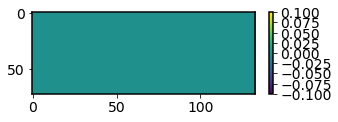

In [19]:
fits_temp=np.zeros([Npix_x,Npix_y,4096])
plt.figure(figsize=(5,1.5))
plt.imshow(fits_temp[:,:,ch_plot].T,aspect='auto')
plt.colorbar()
plt.show()

In [20]:
Sum_Tsky_xy=fits_temp.copy()
Sum_Tresi_xy=fits_temp.copy()
Npix_xy_count1=fits_temp.copy()
Npix_xy_count2=fits_temp.copy()


In [21]:
assert((Tsky_map.mask==Tresi_map.mask).all()==True)

In [22]:
for i in range(len(ra)):
    x_pix,y_pix=x_pix_list[i],y_pix_list[i]
    
    mask1=Tsky_map.mask[i,:]
    if (mask1==True).all()==False:
        Sum_Tsky_xy[x_pix,y_pix,~mask1]+=Tsky_map[i,~mask1]
        Npix_xy_count1[x_pix,y_pix,~mask1]+=1
    
    mask2=Tresi_map.mask[i,:]
    if (mask2==True).all()==False:
        Sum_Tresi_xy[x_pix,y_pix,~mask2]+=Tresi_map[i,~mask2]
        Npix_xy_count2[x_pix,y_pix,~mask2]+=1
   

In [23]:
assert((Npix_xy_count1==Npix_xy_count2).all())

In [24]:
Tsky_xy=Sum_Tsky_xy/Npix_xy_count1
Tresi_xy=Sum_Tresi_xy/Npix_xy_count2

/usr/lib/python2.7/dist-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in divide
  if __name__ == '__main__':
/usr/lib/python2.7/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in divide
  from ipykernel import kernelapp as app


In [25]:
ptr_list=ac.SkyCoord(ra=p_radec[:,0]*u.deg, dec=p_radec[:,1]*u.deg)
ptr_ra_pix,ptr_dec_pix=skycoord_to_pixel(ptr_list,w)

In [26]:
for i in range(len(ptr_list)):
    print ptr_ra_pix[i],ptr_dec_pix[i]

122.595738346 64.1981266401
92.2775148426 -15.1072215175
91.7150315007 -21.8831374928
95.8950093618 -14.4377122662
104.276182153 -4.26095810952
133.479456266 52.2774026274
127.574009471 33.2071015237
127.59048637 33.1706778644
122.36441164 18.95873689
122.35950932 18.9464383492
102.784598475 -19.2234696223
117.713384336 7.61577172771
127.972611997 29.1071953235
135.870636524 47.5059636466
141.919132371 43.9827239397
115.068470795 -14.9315992726
1.10296908272 88.0121472239
2.41248042367 80.6593939067
2.4272849346 45.3690003722
5.95371139771 90.4894965483
6.86857445431 56.6460824936
7.83945999219 80.2594724986
8.16995403995 86.7064800991
8.70677637993 88.4625790183
9.4447936164 5.73047906918
15.56193244 89.8371414407
16.8689956352 90.6566122126
19.1500444723 82.8022206933
17.3075369935 47.721854528
17.7948560566 54.2794508557
23.5295510689 87.4990609461
23.9796780693 87.8271649579
21.8892558408 22.9620744705
21.9234221771 22.9808852624
23.7003603288 37.5837951308
30.902123881 85.63295647

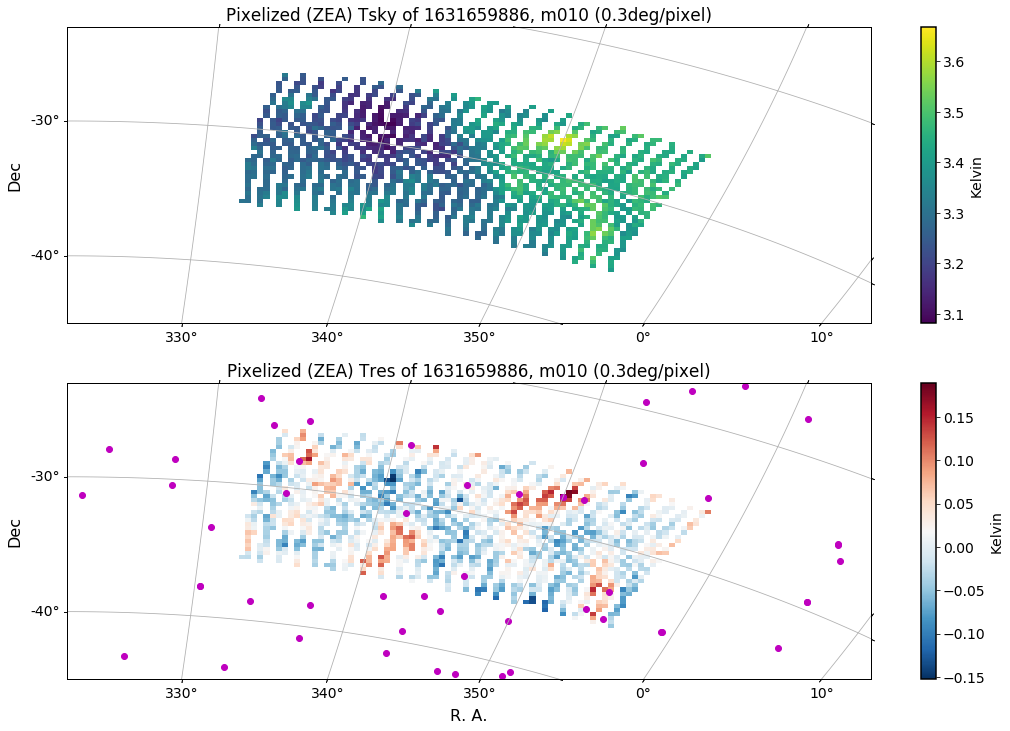

In [27]:
plt.figure(figsize=(18,12))
plt.subplot(211,projection=w)
plt.imshow(Tsky_xy[:,:,ch_plot].T,cmap=kv.cmap1(),aspect='auto')
#plt.gca().invert_yaxis() #only works when no coordinates
plt.colorbar(label='Kelvin')
plt.ylabel('Dec',fontsize=16)
plt.xlim([0,Npix_x])
plt.ylim([0,Npix_y])
plt.grid()
plt.title('Pixelized ('+p_choice+') Tsky of '+fname+', '+ant+' (0.3deg/pixel)')
plt.subplot(212,projection=w)
plt.imshow(Tresi_xy[:,:,ch_plot].T,cmap=kv.cmap2(),aspect='auto')
#plt.gca().invert_yaxis() #only works when no coordinates
plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
plt.colorbar(label='Kelvin')
plt.xlabel('R. A.',fontsize=16)
plt.ylabel('Dec',fontsize=16)
plt.xlim([0,Npix_x])
plt.ylim([0,Npix_y])
plt.grid()
plt.title('Pixelized ('+p_choice+') Tres of '+fname+', '+ant+' (0.3deg/pixel)')
plt.show()

In [28]:
assert((Npix_xy_count1==Npix_xy_count2).all())


In [29]:
print w

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---ZEA'  'DEC--ZEA'  
CRVAL : -38.0  -45.0  
CRPIX : 1.0  1.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.29999999999999999  0.29999999999999999  
NAXIS : 0  0


In [30]:
list=[Sum_Tsky_xy,Sum_Tresi_xy,Npix_xy_count1,Tsky_xy,Tresi_xy]
list_str=['Sum_Tsky_xy','Sum_Tresi_xy','Npix_xy_count','Tsky_xy','Tresi_xy']
for i in range(len(list)):
    hdu=w.to_fits()
    hdu[0].data=list[i]
    hdu.writeto(output_file+fname+'_'+ant+'_'+list_str[i]+'_p'+str(pix_deg)+'d.fits', overwrite=True)

In [31]:
#end

# reload data to check 

In [32]:
Fits='/idia/projects/hi_im/raw_vis/MeerKLASS2021/level5/data/'+fname+'_'+ant+'_'+list_str[-1]+'_p'+str(pix_deg)+'d.fits'
cube = fits.open(Fits)[0].data
print np.shape(cube)

(133, 73, 4096)


In [33]:
w2=WCS(Fits).dropaxis(-1)
print w2

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---ZEA'  'DEC--ZEA'  
CRVAL : -38.0  -45.0  
CRPIX : 1.0  1.0  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : 0.29999999999999999  0.29999999999999999  
NAXIS : 4096  73  133


In [34]:
#check data
assert((cube[~np.isnan(cube)]==Tresi_xy[~np.isnan(Tresi_xy)]).all()==True)

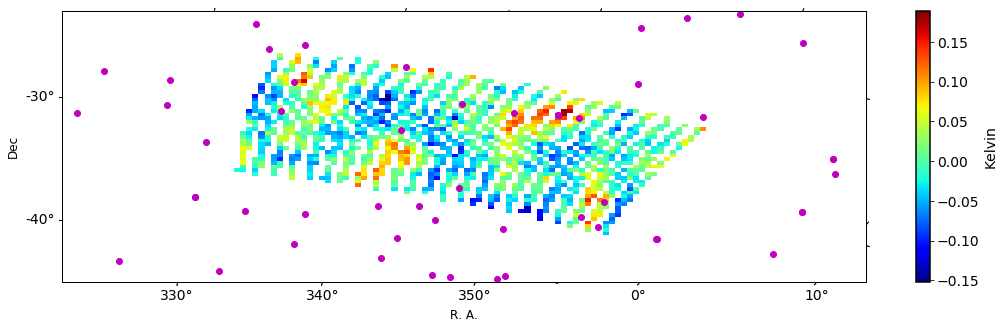

In [35]:
plt.figure(figsize=(18,5))
plt.subplot(projection=w2)
plt.imshow(cube[:,:,ch_plot].T,cmap='jet',aspect='auto')
plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
plt.plot(ptr_ra_pix[22],ptr_dec_pix[22],'mo',ms=12)
plt.colorbar(label='Kelvin')
plt.xlabel('R. A.',fontsize=12)
plt.ylabel('Dec',fontsize=12)
plt.xlim([0,Npix_x])
plt.ylim([0,Npix_y])
plt.show()

In [36]:
print 'end @ ' + time.asctime(time.localtime(time.time())) +'#'

end @ Wed Jun  8 14:10:20 2022#
